In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU,RNN
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.callbacks import TensorBoard

In [2]:
dataset = read_csv('C1.csv')
dataset.fillna(0, inplace=True)
values = dataset.values

In [3]:
df1=dataset['DC Array Output (W)']
df1 = df1.iloc[:-24]
df1

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8732    0.0
8733    0.0
8734    0.0
8735    0.0
8736    0.0
Name: DC Array Output (W), Length: 8737, dtype: float64

Text(0, 0.5, 'DC solar power in Watts')

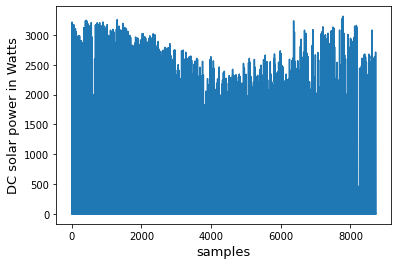

In [4]:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.xlabel('samples',fontsize=13)
plt.ylabel('DC solar power in Watts', fontsize=13)

In [5]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----499   500 
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), numpy.array(dataY)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train,test=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [8]:
time_step = 24
X_train1, y_train1 = create_dataset(train, time_step)
X_test1, ytest1 = create_dataset(test, time_step)

In [9]:
print(X_train1.shape,y_train1.shape)

(6090, 24) (6090,)


In [10]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train1 =X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)

In [11]:
from keras import Input # for instantiating a keras tensor
model = Sequential(name="Model-with-One-Input") # Model
model.add(Input(shape=(24,), name='Input-Layer')) # Input Layer 
model.add(Dense(24, activation='softplus', name='Hidden-Layer')) # Hidden Layer
model.add(Dense(1, activation='relu', name='Output-Layer')) # Output Layer
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='mean_squared_error')
model.summary()

Model: "Model-with-One-Input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer (Dense)        (None, 24)                600       
                                                                 
 Output-Layer (Dense)        (None, 1)                 25        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [12]:
import time 
tic = time.time()
model.fit(X_train1,y_train1,validation_data = (X_test1,ytest1),epochs=50,batch_size=64,verbose=1)
toc = time.time()
print('running time' + str(toc-tic) + ' ' + 's')

Epoch 1/50
96/96 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 4/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 5/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 6/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 7/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 8/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 9/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0073
Epoch 10/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 11/50
96/96 [

Text(0, 0.5, 'loss')

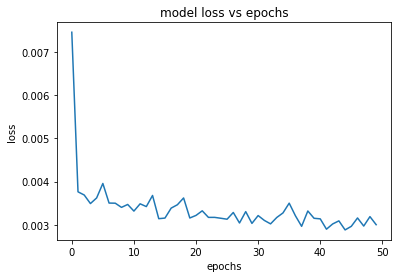

In [13]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
pyplot.title('model loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [14]:
train_predict=model.predict(X_train1) 
test_predict=model.predict(X_test1)
#Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train=y_train1.reshape(y_train1.shape[0],1)
y_train=scaler.inverse_transform(y_train)
y_train

array([[  0.   ],
       [  0.   ],
       [  0.   ],
       ...,
       [378.714],
       [ 85.92 ],
       [ 16.645]])

In [15]:
ytest=ytest1.reshape(ytest1.shape[0],1)
ytest=scaler.inverse_transform(ytest)

In [16]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(ytest,test_predict))

275.76523702951

MSE=76046.46595394182
R2=0.9176446266324977
RMSE=275.76523702951
MAE=139.2013538069079


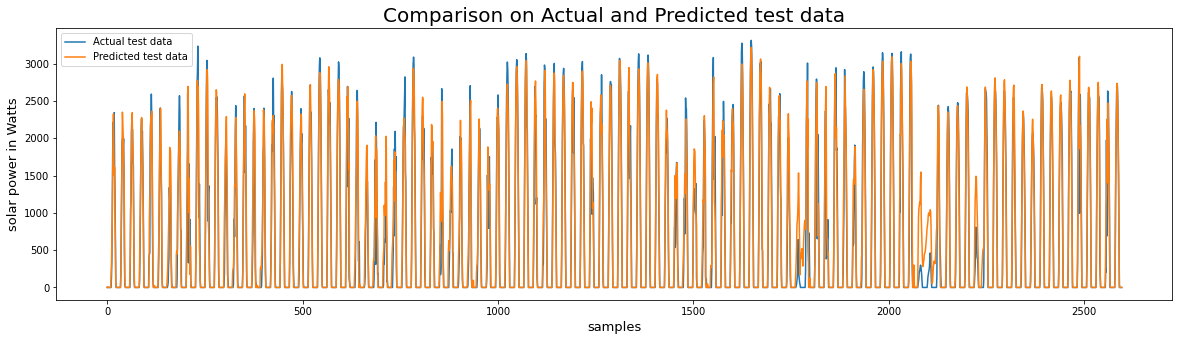

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,5)
from sklearn.metrics import *
from math import sqrt
MSE = mean_squared_error(ytest,test_predict)
R2 = r2_score(ytest,test_predict) # regression score(ratio of actual vs predicted)
RMSE = sqrt(mean_squared_error(ytest,test_predict))
MAE = mean_absolute_error(ytest,test_predict)
print("MSE={}".format(MSE))
print("R2={}".format(R2))
print("RMSE={}".format(RMSE))
print("MAE={}".format(MAE))
#plotting predicted test value vs actual test value
plt.title("Comparison on Actual and Predicted test data",fontsize=20)
plt.plot(ytest, label = 'Actual test data')
plt.plot(test_predict, label = 'Predicted test data')
plt.xlabel('samples',fontsize=13)
plt.ylabel('solar power in Watts', fontsize=13)
plt.legend()
plt.show()

Text(1, 2800, 'R-squared = 0.918')

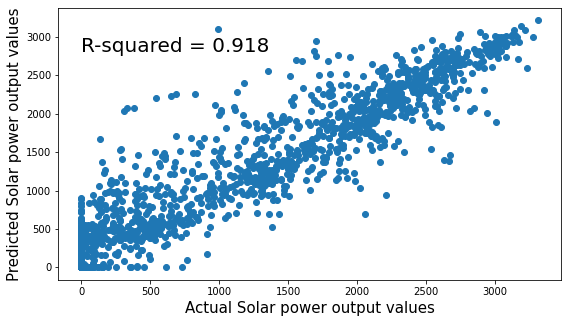

In [18]:
import numpy as np
import matplotlib.pyplot as plt
r_squared =R2
plt.rcParams['figure.figsize'] = (9,5)
plt.scatter(ytest,test_predict)
plt.xlabel('Actual Solar power output values', fontsize=15)
plt.ylabel('Predicted Solar power output values', fontsize=15)
plt.annotate("R-squared = {:.3f}".format(r2_score(ytest,test_predict)), (1,2800),fontsize=20)